### Distributed Training 
[official guide](https://www.tensorflow.org/tutorials/distribute/keras)

## Overview
The tf.distribute.Strategy API provides an abstraction for distributing your training across multiple processing units. The goal is to allow users to enable distributed training using existing models and training code, with minimal changes.

`MirroredStrategy` is one of several distribution strategy available in TensorFlow core. You can read about more strategies at  [distribution strategy guide](https://www.tensorflow.org/guide/distributed_training)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()
tf.__version__

'2.0.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# GPU 메모리 제한하기
MEMORY_LIMIT_CONFIG = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
print(MEMORY_LIMIT_CONFIG)
tf.config.experimental.set_virtual_device_configuration(gpus[0], MEMORY_LIMIT_CONFIG)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[VirtualDeviceConfiguration(memory_limit=2048)]


In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download the dataset
Setting with_info to True includes the metadata for the entire dataset, which is being saved here to info. Among other things, this metadata object includes the number of train and test examples

In [4]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)
mnist_train, mnist_test = datasets['train'], datasets['test']

In [5]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [6]:
print(mnist_train.element_spec, '\n', mnist_test.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) 
 (TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [7]:
strategy = tf.distribute.MirroredStrategy()

In [8]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [9]:
info.splits.total_num_examples

70000

## Setup input pipeline

In [10]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
BUFFER_SIZE = 10000
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print("BATCH_SIZE: {}, NUMBER_GPUS: {}".format(BATCH_SIZE, strategy.num_replicas_in_sync))

BATCH_SIZE: 64, NUMBER_GPUS: 1


In [11]:
# normalization
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255

    return image, label

train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

In [12]:
img_batch, label_batch = next(iter(train_dataset))
print('In a minibatch, image.shape: {}, label.shape: {}'.format(img_batch.shape, label_batch.shape))

In a minibatch, image.shape: (64, 28, 28, 1), label.shape: (64,)


## Create the model
Create and compile the Keras model <font color=red>in the context of strategy.scope</font>.

In [13]:
with strategy.scope():
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')])

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [14]:
# Define the checkpoint directory to store the checkpoints
root_dir = './distribute'
checkpoint_dir = os.path.join(root_dir, 'checkpoints')
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# tensorboard logs directory 
logs_dir = os.path.join(root_dir, 'logs')

In [15]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3: return 1e-3
    elif epoch >= 3 and epoch < 7: return 1e-4
    else: return 1e-5
    
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logs_dir),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()]

## Train and evaluate

In [16]:
# callbacks: List of keras.callbacks.Callback instances. List of callbacks to apply during training. See tf.keras.callbacks.
history = model.fit(train_dataset, epochs=5, callbacks=callbacks)

Epoch 1/5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


    938/Unknown - 9s 9ms/step - loss: 0.2027 - accuracy: 0.9422
Learning rate for epoch 1 is 0.0010000000474974513
938/938 [==============================] - 9s 9ms/step - loss: 0.2027 - accuracy: 0.9422
Epoch 2/5
932/938 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9805
Learning rate for epoch 2 is 0.0010000000474974513
938/938 [==============================] - 3s 3ms/step - loss: 0.0659 - accuracy: 0.9804
Epoch 3/5
926/938 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9861
Learning rate for epoch 3 is 0.0010000000474974513
938/938 [==============================] - 3s 3ms/step - loss: 0.0449 - accuracy: 0.9862
Epoch 4/5
935/938 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9928
Learning rate for epoch 4 is 9.999999747378752e-05
938/938 [==============================] - 3s 3ms/step - loss: 0.0248 - accuracy: 0.9928
Epoch 5/5
924/938 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9

In [17]:
# check the checkpoint directory
print(checkpoint_dir)
!ls {checkpoint_dir}

./distribute/checkpoints
checkpoint		     ckpt_4.data-00000-of-00002
ckpt_10.data-00000-of-00002  ckpt_4.data-00001-of-00002
ckpt_10.data-00001-of-00002  ckpt_4.index
ckpt_10.index		     ckpt_5.data-00000-of-00002
ckpt_11.data-00000-of-00002  ckpt_5.data-00001-of-00002
ckpt_11.data-00001-of-00002  ckpt_5.index
ckpt_11.index		     ckpt_6.data-00000-of-00002
ckpt_12.data-00000-of-00002  ckpt_6.data-00001-of-00002
ckpt_12.data-00001-of-00002  ckpt_6.index
ckpt_12.index		     ckpt_7.data-00000-of-00002
ckpt_1.data-00000-of-00002   ckpt_7.data-00001-of-00002
ckpt_1.data-00001-of-00002   ckpt_7.index
ckpt_1.index		     ckpt_8.data-00000-of-00002
ckpt_2.data-00000-of-00002   ckpt_8.data-00001-of-00002
ckpt_2.data-00001-of-00002   ckpt_8.index
ckpt_2.index		     ckpt_9.data-00000-of-00002
ckpt_3.data-00000-of-00002   ckpt_9.data-00001-of-00002
ckpt_3.data-00001-of-00002   ckpt_9.index
ckpt_3.index


In [18]:
vars(history).keys()

dict_keys(['validation_data', 'model', '_chief_worker_only', 'params', 'epoch', 'history'])

In [19]:
vars(history)['params']

{'batch_size': None,
 'epochs': 5,
 'steps': 938,
 'samples': None,
 'verbose': 1,
 'do_validation': False,
 'metrics': ['loss', 'accuracy']}

In [20]:
vars(history)['history'].keys()

dict_keys(['loss', 'accuracy', 'lr'])

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']
epochs = range(1, len(acc) + 1)

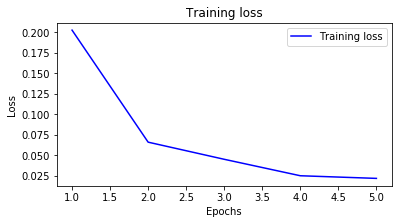

In [22]:
plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

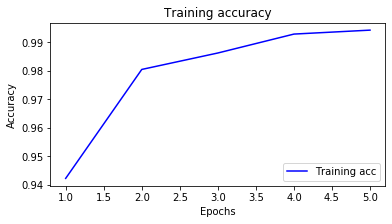

In [23]:
plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [24]:
img_batch, label_batch = next(iter(eval_dataset))
print(img_batch.shape, label_batch.shape)

(64, 28, 28, 1) (64,)


In [25]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
eval_loss, eval_acc = model.evaluate(eval_dataset)
print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


157/157 [==============================] - 2s 13ms/step - loss: 0.0399 - accuracy: 0.9855
Eval loss: 0.03992713437338544, Eval Accuracy: 0.9854999780654907


In [26]:
!ls -sh $logs_dir

total 4.0K
4.0K train


copy and paste url:http://125.191.6.186:6006/

```shell
$ tensorboard --logdir=./distribute/logs
```

## Export to SavedModel

<font color=red>Export the graph and the variables</font> to the platform-agnostic SavedModel format. After your model is saved, you can load it with or without the scope.

In [27]:
path = os.path.join(root_dir, 'saved_model/')

In [28]:
model.save(path, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Assets written to: ./distribute/saved_model/assets


INFO:tensorflow:Assets written to: ./distribute/saved_model/assets


In [29]:
print(path)
!ls -sh $path

./distribute/saved_model/
total 116K
4.0K assets  108K saved_model.pb  4.0K variables


Load the model without `strategy.scope`

In [30]:
unreplicated_model = tf.keras.models.load_model(path)

unreplicated_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

eval_loss, eval_acc = unreplicated_model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

157/157 [==============================] - 1s 6ms/step - loss: 0.0399 - accuracy: 0.9855
Eval loss: 0.039927506513128375, Eval Accuracy: 0.9854999780654907


Load the model with `strategy.scope`.

In [31]:
# with strategy.scope():
#     replicated_model = tf.keras.models.load_model(path)
#     replicated_model.compile(loss='sparse_categorical_crossentropy',
#                            optimizer=tf.keras.optimizers.Adam(),
#                            metrics=['accuracy'])

#     eval_loss, eval_acc = replicated_model.evaluate(eval_dataset)
#     print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))